In [22]:
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.transforms as trans
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from PIL import Image 
import matplotlib.pyplot as plt 
import os 
import time 

# Global Variable

In [23]:
path_label_train = 'E:/data/DeepLearning/celeba/list_attr_celeba.csv'
path_label_test = 'E:/data/DeepLearning/celeba/test_list_attr_celeba.csv'
path_image_train = 'E:/data/DeepLearning/celeba/img_align_celeba/'
path_image_test = 'E:/data/DeepLearning/celeba/img_align_celeba/'
crop_size = 178
image_size = 128
batch_size = 8 # 8
channel_g = 64
depth_g = 6
depth_d = 5
channel_d = 64
learning_rate_g = 1e-4
learning_rate_d = 1e-4
λ_src = 1
λ_cls = 1
λ_gp = 10
λ_rec = 10
step_g = 5
path_work = "D:/model/starganp/model/"
iterations = 202599 * 200
num_workers = 0
device = T.device("cuda:0")

# Data

In [24]:
class Dataset_(Dataset):
    #
    def __init__(self, path_label=path_label_train, path_image=path_image_train):
        with open(path_label) as f:
            self.list_ = f.readlines()
        self.path_image = path_image
        self.transform = trans.Compose([trans.CenterCrop(crop_size),
                                        trans.Resize(image_size, Image.BICUBIC),
                                        trans.RandomHorizontalFlip(),
                                        trans.ToTensor(),
                                        trans.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])
    #
    def load_image_and_label(self, list_, path_image):
        idx = np.random.randint(len(self.list_))
        line = list_[idx].replace('\n','').split(',')
        image = Image.open(path_image + line[0])
        image = self.transform(image)
        label = T.from_numpy(np.array([line[9], line[10], line[12], line[21], line[40]], dtype='float32').reshape(5,1,1)) * 0.5 + 0.5
        return image, label
    #
    def __getitem__(self, idx):
        image_a, label_a = self.load_image_and_label(self.list_, self.path_image)
        image_b, label_b = self.load_image_and_label(self.list_, self.path_image)
        return image_a, label_a, image_b, label_b
    #
    def __len__(self):
        return iterations

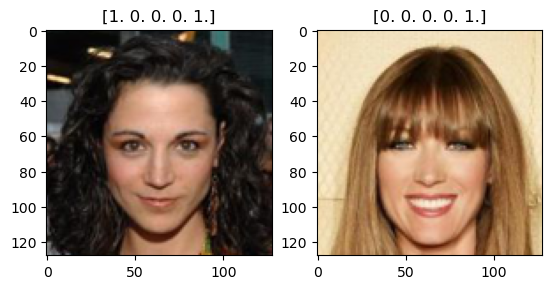

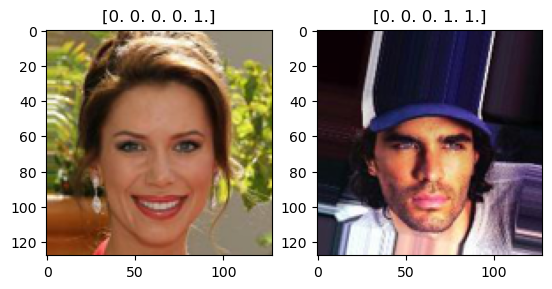

In [25]:
dataloader = DataLoader(Dataset_(), batch_size=1)
n = 0
for image_a, label_a, image_b, label_b in dataloader:
    if n == 2:
        break
    image_a = image_a.squeeze().numpy().transpose([1,2,0]) * 0.5 + 0.5
    image_b = image_b.squeeze().numpy().transpose([1,2,0]) * 0.5 + 0.5
    plt.subplot(1,2,1), plt.imshow(image_a), plt.title(np.squeeze(label_a.numpy()))
    plt.subplot(1,2,2), plt.imshow(image_b), plt.title(np.squeeze(label_b.numpy()))
    plt.show()
    n += 1

# Network Structure

## Generator

In [26]:
class CIN(nn.Module):
    #
    def __init__(self, channels_feature, channels_condition):
        super().__init__()
        channels = channels_feature + channels_condition
        self.fc_mean = nn.Sequential(nn.Conv2d(channels, channels, 1), nn.ReLU(), nn.Conv2d(channels, channels_feature, 1))
        self.fc_std = nn.Sequential(nn.Conv2d(channels, channels, 1), nn.ReLU(), nn.Conv2d(channels, channels_feature, 1))
    #
    def forward(self, x, c):
        mean = T.mean(x, dim=[2,3], keepdim=True)
        std = T.sqrt(T.var(x, dim=[2,3], keepdim=True) + 1e-5)
        mean_c = T.cat([mean, c], dim=1)
        std_c = T.cat([std, c], dim=1)
        print('---', self.fc_mean(mean_c).min(), self.fc_mean(mean_c).max(), self.fc_std(std_c).min(), self.fc_std(std_c).max())
        mean_c = self.fc_mean(mean_c) + mean
        std_c = self.fc_std(std_c) + std
        print('===', mean.min(), mean.max(), std.min(), std.max())
        return (x - mean) / std * std_c + mean_c

In [27]:
class CNA(nn.Module):
    #
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, channels_condition, is_conv=True, is_act=True):
        super().__init__()
        if is_conv:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.norm = CIN(out_channels, channels_condition)
        if is_act:
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
    #
    def forward(self, x, c):
        x = self.conv(x)
        x = self.norm(x, c)
        x = self.act(x)
        return x

In [28]:
class ResBlock(nn.Module):
    #
    def __init__(self, channel, channels_condition):
        super().__init__()
        self.layers = nn.ModuleList([CNA(channel, channel, 3, 1, 1, channels_condition, True, True), 
                                     CNA(channel, channel, 3, 1, 1, channels_condition, True, False)])
    #
    def forward(self, x, c):
        y = x.clone()
        for layer in self.layers:
            x = layer(x, c)
        return x + y

In [29]:
class Generator(nn.Module):
    #
    def __init__(self, channel=channel_g, depth=depth_g, channels_condition=5):
        super().__init__()
        self.conv1 = CNA(3, channel, 7, 1, 3, channels_condition, True)
        self.layers = nn.ModuleList()
        self.layers.append(CNA(channel, channel*2, 4, 2, 1, channels_condition, True))
        self.layers.append(CNA(channel*2, channel*4, 4, 2, 1, channels_condition, True))
        for _ in range(depth):
            self.layers.append(ResBlock(channel*4, channels_condition))
        self.layers.append(CNA(channel*4, channel*2, 4, 2, 1, channels_condition, False))
        self.layers.append(CNA(channel*2, channel, 4, 2, 1, channels_condition, False))
        self.conv2 = nn.Conv2d(channel, 3, 7, 1, 3, bias=False)
    #
    def forward(self, x, c):
        x = self.conv1(x, c)
        # y = x.clone()
        for layer in self.layers:
            x = layer(x, c)
        # x = x + y
        x = self.conv2(x)
        return x

## Discriminator

In [30]:
class Discriminator(nn.Module):
    #
    def __init__(self, channel=channel_d, depth=depth_d):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(3, channel, 4, 2, 1, bias=False),
            nn.LeakyReLU()
        ])
        for i in range(depth):
            self.layers.append(nn.Conv2d(channel*2**i, channel*2**(i+1), 4, 2, 1, bias=False))
            self.layers.append(nn.LeakyReLU())
        self.D_src = nn.Conv2d(channel*2**(i+1), 1, 3, 1, 1, bias=False)
        self.D_cls = nn.Conv2d(channel*2**(i+1), 5, [image_size//2**(1+depth), image_size//2**(1+depth)], 1, 0, bias=False)
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        src = self.D_src(x)
        cls = self.D_cls(x)
        return src, cls

# Show


--- tensor(-0.2098, device='cuda:0') tensor(0.2161, device='cuda:0') tensor(-0.2292, device='cuda:0') tensor(0.2348, device='cuda:0')
=== tensor(-0.3141, device='cuda:0') tensor(0.2502, device='cuda:0') tensor(0.0603, device='cuda:0') tensor(0.5574, device='cuda:0')
--- tensor(-0.2121, device='cuda:0') tensor(0.1520, device='cuda:0') tensor(-0.1902, device='cuda:0') tensor(0.1574, device='cuda:0')
=== tensor(-0.2450, device='cuda:0') tensor(0.2573, device='cuda:0') tensor(0.0297, device='cuda:0') tensor(0.2521, device='cuda:0')
--- tensor(-0.1043, device='cuda:0') tensor(0.1322, device='cuda:0') tensor(-0.1363, device='cuda:0') tensor(0.1653, device='cuda:0')
=== tensor(-0.1952, device='cuda:0') tensor(0.1573, device='cuda:0') tensor(0.0176, device='cuda:0') tensor(0.1052, device='cuda:0')
--- tensor(-0.1080, device='cuda:0') tensor(0.1304, device='cuda:0') tensor(-0.1154, device='cuda:0') tensor(0.1356, device='cuda:0')
=== tensor(-0.1112, device='cuda:0') tensor(0.0974, device='cuda:

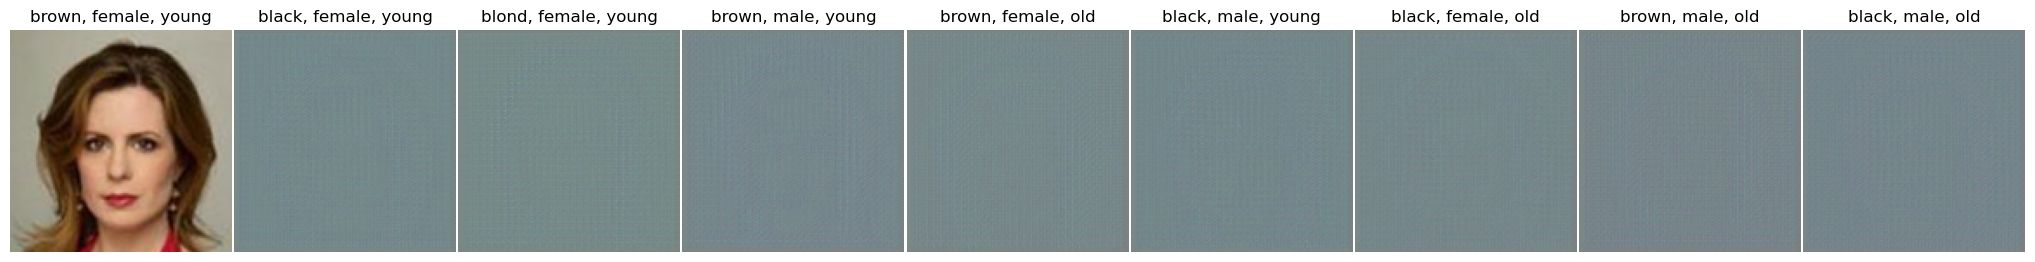

In [31]:
@T.no_grad()
def show(GG=None):
    if GG==None:
        GG = Generator().to(device)
    GG.eval()
    fig = plt.figure(figsize=(26, 3))
    gs = plt.GridSpec(1, 9)
    gs.update(wspace=0.01, hspace=0.01)
    image0 = Image.open('E:/data/DeepLearning/celeba/img_align_celeba/002044.jpg')#002044, 000077
    image0 = image0.crop([0,20,178,198])
    image0 = image0.resize((128,128),Image.BICUBIC)
    image0 = np.array(image0).astype("float32").transpose([2, 0, 1]).reshape(1,3,128,128) / 255 * 2 - 1
    images0 = np.tile(image0,(8,1,1,1))
    att1, att2, att3, att4, att5 = 0, 0, 1, 0, 1 #棕发、女、年轻 
    att_list = ['brown, female, young', 'black, female, young', 'blond, female, young', 'brown, male, young', 'brown, female, old', 'black, male, young', 'black, female, old', 'brown, male, old', 'black, male, old']
    labels = np.empty([8,5,1,1], dtype = 'float32')
    labels[0,:,:,:] = np.array([[[[1-att1]], [[att2]],[[1-att3]],[[att4]],[[att5]]]]) #黑发、女、年轻
    labels[1,:,:,:] = np.array([[[[att1]], [[1-att2]],[[1-att3]],[[att4]],[[att5]]]]) #金发、女、年轻
    labels[2,:,:,:] = np.array([[[[att1]], [[att2]],[[att3]],[[1-att4]],[[att5]]]]) #棕发、男、年轻
    labels[3,:,:,:] = np.array([[[[att1]], [[att2]],[[att3]],[[att4]],[[1-att5]]]]) #棕发、女、年老
    labels[4,:,:,:] = np.array([[[[1-att1]], [[att2]],[[1-att3]],[[1-att4]],[[att5]]]]) #黑发、男、年轻
    labels[5,:,:,:] = np.array([[[[1-att1]], [[att2]],[[1-att3]],[[att4]],[[1-att5]]]]) #黑发、女、年老
    labels[6,:,:,:] = np.array([[[[att1]], [[att2]],[[att3]],[[1-att4]],[[1-att5]]]]) #棕发、男、年老
    labels[7,:,:,:] = np.array([[[[1-att1]], [[att2]],[[1-att3]],[[1-att4]],[[1-att5]]]]) #黑发、男、年老
    images998 = GG(T.from_numpy(images0).to(device), T.from_numpy(labels.astype('float32')).to(device)).cpu().numpy()
    images998 = np.concatenate((image0, images998),axis = 0)
    n = 0
    for j in range(9):
        ax = plt.subplot(gs[n])
        n += 1
        image = (images998[j,:,:,:].reshape(3,128,128).transpose(1,2,0)+1)/2
        image = np.maximum(image, 0)
        image = np.minimum(image, 1)
        # image = Image.fromarray(np.uint8(image*255))
        plt.imshow(image)  
        plt.title(att_list[j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
    plt.show()


show()

# Train

In [32]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = T.ones(y.shape).to(device)
    dydx = T.autograd.grad(y, x, grad_outputs=weight, retain_graph=True, create_graph=True)[0]
    dydx = dydx.reshape([dydx.shape[0], -1])
    dydx_l2norm = T.sqrt(T.sum(dydx**2, axis=1))
    return T.mean((dydx_l2norm-1)**2)

In [33]:
def trainer_d(image_a, image_b, label_b, net_g, net_d, optimizer_d):
    #
    image_a2b = net_g(image_a, label_b)
    src_b, cls_b = net_d(image_b)
    src_a2b, _ = net_d(image_a2b.detach())
    # gp
    α = T.rand([label_b.shape[0], 1, 1, 1]).to(device)
    image_fusion = α*image_b + (1-α)*image_a2b
    src_fusion, _ = net_d(image_fusion)
    #
    loss_src = -T.mean(src_b) + T.mean(src_a2b)
    # loss_cls = P.mean(-label_b*P.log(F.sigmoid(cls_b)+1e-8) - (1-label_b)*P.log(1-F.sigmoid(cls_b)+1e-8)) 
    loss_cls = F.binary_cross_entropy_with_logits(cls_b, label_b)
    loss_gp = gradient_penalty(src_fusion, image_fusion)
    loss = λ_src*loss_src + λ_cls*loss_cls + λ_gp*loss_gp
    #
    # net_d.zero_gradients()
    optimizer_d.zero_grad()
    loss.backward()
    optimizer_d.step()
        

In [34]:
def trainer_g(image_a, label_a, label_b, net_g, net_d, optimizer_g):
    #
    image_a2b = net_g(image_a, label_b)
    src_a2b, cls_a2b = net_d(image_a2b)
    image_a2b2a = net_g(image_a2b, label_a)
    #
    loss_src = -T.mean(src_a2b)
    loss_rec = T.mean(T.abs(image_a-image_a2b2a))
    # loss_cls = P.mean(-label_b*P.log(F.sigmoid(cls_a2b)+1e-8)-(1-label_b)*P.log(1-F.sigmoid(cls_a2b)+1e-8))
    loss_cls = F.binary_cross_entropy_with_logits(cls_a2b, label_b)
    loss = λ_src*loss_src + λ_rec*loss_rec + λ_cls*loss_cls
    #
    optimizer_g.zero_grad()
    loss.backward()
    optimizer_g.step()

In [35]:
def train(iteration=1000000, load_model=False):
    #
    iteration_ = np.load(path_work + 'iteration.npy', allow_pickle=True).item() if load_model else 0
    net_g = Generator().to(device)
    net_d = Discriminator().to(device)
    # net_d.train()
    optimizer_g = T.optim.Adam(net_g.parameters(), learning_rate_g, betas=(0.5,0.999))
    optimizer_d = T.optim.Adam(net_d.parameters(), learning_rate_d, betas=(0.5,0.999))
    if load_model:
        net_g.load_state_dict(T.load(path_work + 'net_g.pt'))
        optimizer_g.load_state_dict(T.load(path_work + 'optimizer_g.pt'))
        net_d.load_state_dict(T.load(path_work + 'net_d.pt'))
        optimizer_d.load_state_dict(T.load(path_work + 'optimizer_d.pt'))
    #
    time_start = time.time()
    dataloader = DataLoader(Dataset_(), batch_size=batch_size, shuffle=True, num_workers=num_workers)
    for image_a, label_a, image_b, label_b in dataloader:
        if iteration_ >= iteration:
            break
        iteration_ += 1
        net_g.train()        
        image_a, image_b, label_a, label_b = image_a.to(device), image_b.to(device), label_a.to(device), label_b.to(device)
        trainer_d(image_a, image_b, label_b, net_g, net_d, optimizer_d)
        if iteration_ % step_g == 0:
            trainer_g(image_a, label_a, label_b, net_g, net_d, optimizer_g)
    #
        if iteration_ % 1000 == 0:
            print('Iteration: ', iteration_)    
            show(net_g)        
            T.save(net_d.state_dict(), path_work + 'net_d.pt')
            T.save(optimizer_d.state_dict(), path_work + 'optimizer_d.pt')
            T.save(net_g.state_dict(), path_work + 'net_g.pt')
            T.save(optimizer_g.state_dict(), path_work + 'optimizer_g.pt')
            np.save(path_work + 'iteration.npy', iteration_)
            print('These iterations cost {} seconds'.format(time.time() - time_start))
            time_start = time.time()

In [36]:
# train(iteration=iterations, load_model=False)

In [37]:
# train(iteration=iterations, load_model=True)

# Test

--- tensor(-0.3828, device='cuda:0') tensor(1.4731, device='cuda:0') tensor(-0.4991, device='cuda:0') tensor(0.1056, device='cuda:0')
=== tensor(-0.3540, device='cuda:0') tensor(0.3288, device='cuda:0') tensor(0.0125, device='cuda:0') tensor(0.7782, device='cuda:0')
--- tensor(-0.2364, device='cuda:0') tensor(0.2269, device='cuda:0') tensor(-0.3021, device='cuda:0') tensor(0.1984, device='cuda:0')
=== tensor(-0.6921, device='cuda:0') tensor(0.2208, device='cuda:0') tensor(0.0478, device='cuda:0') tensor(0.4429, device='cuda:0')
--- tensor(-0.1182, device='cuda:0') tensor(0.0877, device='cuda:0') tensor(-0.3851, device='cuda:0') tensor(0.1784, device='cuda:0')
=== tensor(-1.0434, device='cuda:0') tensor(0.5328, device='cuda:0') tensor(0.0529, device='cuda:0') tensor(0.9924, device='cuda:0')
--- tensor(-1.1503, device='cuda:0') tensor(0.2333, device='cuda:0') tensor(-0.2463, device='cuda:0') tensor(0.2164, device='cuda:0')
=== tensor(-1.6894, device='cuda:0') tensor(0.1920, device='cuda:

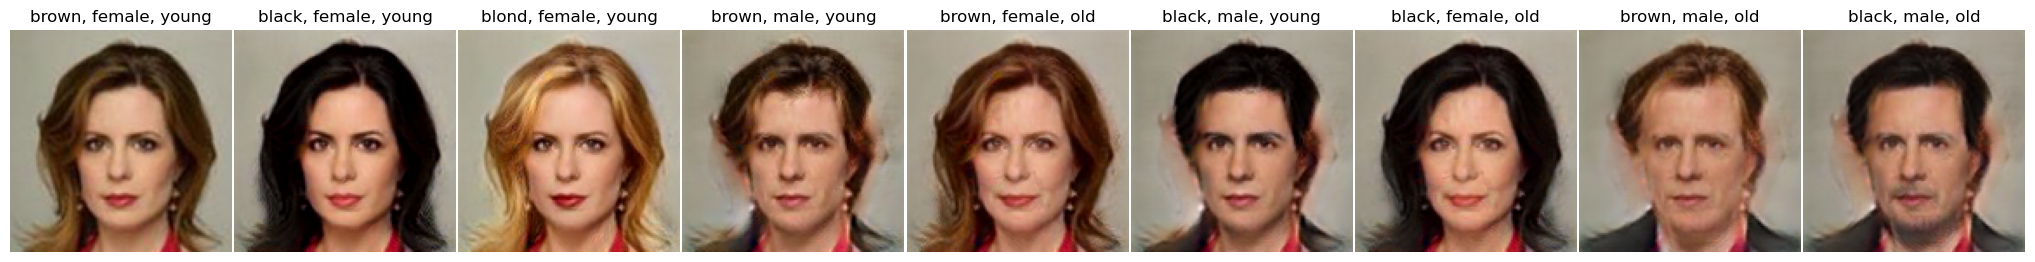

In [38]:
net_g = Generator().to(device)
net_g.load_state_dict(T.load(path_work + 'net_g.pt'))
show(net_g)